## This is the 2D testcase of the echoRD model with stochastic soil definitions
### New version for generic cases based on pre-defined macropore definitions

Make sure to have the dependencies numpy, pandas, scipy, matplotlib and echoRD installed.
This is the Python 3 version.

### Preamble

In [1]:
import numpy as np
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import scipy as sp
import matplotlib.pyplot as plt
import os, sys

In [3]:
#connect echoRD Tools
pathdir='../echoRD/' #path to echoRD
lib_path = os.path.abspath(pathdir)
sys.path.append(lib_path)
import vG_conv as vG
from hydro_tools import plotparticles_t,hydroprofile,plotparticles_weier,stochmod

In [4]:
try:
   import cPickle as pickle
except:
   import pickle


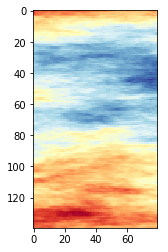

In [5]:
smx=stochmod(0.7,0.4,0.005,0.005,2,10,0.5)
imshow(smx,cmap='RdYlBu')


In [6]:
import mcini_weierbach_Y05 as mcx

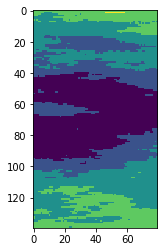

In [7]:
smx = stochmod(-mcx.soildepth,mcx.mxwidth,mcx.grid_sizefac,mcx.grid_sizefac,2,10,0.5)
#imshow(smx,cmap='RdYlBu')
imshow((smx-smx.min().min()).astype(int))

In [8]:
mcx.stochsoil='stoch_modelY05d.h5'

In [9]:
#load soil definitions
soilmatrix=pd.read_csv(mcx.matrixbf, sep=' ')
soilmatrix

,no,ks,ts,tr,alpha,n,rho,z,name
0,1,0.000002,0.475,0.025,1.94,1.208,1500.0,-0.2,topweier_new
1,2,0.000006,0.460,0.060,1.50,1.360,1500.0,-0.1,loess_erwin
2,3,0.000006,0.470,0.110,5.90,1.230,1500.0,-0.1,loesslehm_IUP
3,4,0.000002,0.400,0.040,1.90,1.250,1500.0,-0.1,schwemmloess_IUP
4,5,0.000001,0.460,0.060,1.50,1.360,1500.0,-0.1,loess_AP
5,6,0.000008,0.410,0.120,5.30,1.170,1500.0,-0.1,loesslehm_AP
6,7,0.000004,0.430,0.110,1.20,1.200,1500.0,-0.1,schwemmloess_AP


In [10]:
dpoints=int(mcx.t_end/mcx.t_out)

import h5py
with h5py.File(mcx.stochsoil, 'w') as f:
    dset = f.create_dataset("soil_id", np.shape(smx), dtype='i')
    dset[:,:] =  (smx-smx.min().min()).astype(int)
    dset1 = f.create_dataset('soil_def', data=soilmatrix.values[:,:-1].astype(float))
    dset1.attrs['index'] = np.array(soilmatrix.columns[:-1].tolist(), dtype='S')
    #dset2 = f.create_dataset("particles", np.shape(smx)+(dpoints,), dtype='i')
    dset2 = f.create_dataset("theta", np.shape(smx)+(dpoints,), dtype='f')
    #dset2 = f.create_dataset("data", np.shape(smx)+(1,), maxshape=np.shape(smx)+(None,))
    #dset2[:,:,:] =  (smx-smx.min().min()).astype(int)

print('new stochastic soil data written to: '+mcx.stochsoil)

/Users/cojack/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


new stochastic soil data written to: stoch_modelY05d.h5


### Prepare echoRD

used stochastic soil definitions


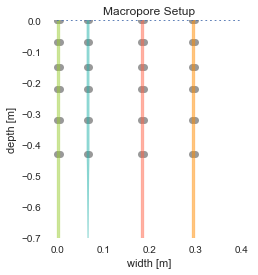

MODEL SETUP READY.
wrote mc to weierbach_Y05.pickle3


In [12]:
#connect to echoRD
import run_echoRD as rE
#connect and load project
[dr,mc,mcp,pdyn,cinf,vG]=rE.loadconnect(pathdir='../',mcinif='mcini_weierbach_Y05',experimental=True)
mc=rE.preproc_echoRD(mc, dr, mcp,'weierbach_Y05.pickle3')
#mc = mcp.mcpick_out(mc,'weierbach_z05.pickle3')
runname='weiherbach_Y05a'
mc.advectref='Shipitalo'

In [12]:
#import macropore_ini as mpo
#mpo.mac_plot(mc.macP,mc,'macs_'+runname+'.pdf')

In [13]:
mc.md_macdepth

array([0.7  , 0.7  , 0.7  , 0.615])

In [14]:
mc.precf

'irr_weier1.dat'

[1 2 3 4]


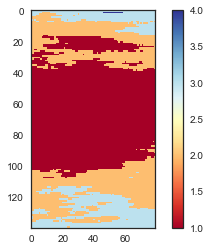

In [15]:
imshow(mc.soilgrid,interpolation=None,cmap='RdYlBu') 
colorbar()
print(np.unique(mc.soilgrid))

In [16]:
mc.mgrid

,vertgrid,latgrid,vertfac,latfac,width,depth
0,140,80,-0.005,0.005,0.4,-0.7


In [17]:
precTS=pd.read_csv(mc.precf, sep=',',skiprows=3)
precTS

,tstart,tend,total,intense,conc
0,360,7560,0.0399,0.000006,0.000165


In [20]:
#use modified routines for binned retention definitions
#mc.part_sizefac=500
mc.gridcellA=mc.mgrid.vertfac*mc.mgrid.latfac
mc.particleA=abs(mc.gridcellA.values)/(2*mc.part_sizefac) #assume average ks at about 0.5 as reference of particle size
mc.particleD=2.*np.sqrt(mc.particleA/np.pi)
mc.particleV=3./4.*np.pi*(mc.particleD/2.)**3.
mc.particleV/=np.sqrt(abs(mc.gridcellA.values)) #assume grid size as 3rd dimension
mc.particleD/=np.sqrt(abs(mc.gridcellA.values))
mc.particlemass=dr.waterdensity(np.array(20),np.array(-9999))*mc.particleV #assume 20°C as reference for particle mass
                                                                        #DEBUG: a) we assume 2D=3D; b) change 20°C to annual mean T?


In [21]:
mc.inimf

'ini_moist5.dat'

In [22]:
mc=dr.ini_bins(mc)
mc=dr.mc_diffs(mc,np.max(np.max(mc.mxbin)))
[mc,particles,npart]=dr.particle_setup(mc,True)
mc = rE.check_lookups(mc)


In [62]:
#mc.inimf='./moisture/07_4_1_moist.dat'
#[mc,particles,npart]=dr.particle_setup(mc,True)
#mc = rE.check_lookups(mc)

In [23]:
#test particle to hdf5
particles.to_hdf('./results/P_'+runname+'.h5','table')

Text(0.5,1,'exfiltration time [s] at pore wall at different theta*')

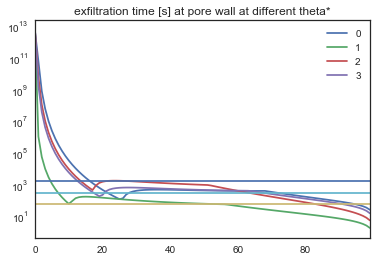

In [24]:
#non-particle setting dependent infiltration breakpoint
dummy=np.zeros((100,len(np.unique(mc.soilgrid))))
j=0
for soil in np.unique(mc.soilgrid)-1:
    #plot(i,(mc.theta100[100-i,4]/(mc.particleD*0.5))*mc.D100[i,4]+mc.ku100[i,4],'.') #q
    for i in np.arange(100):
        dummy[i,j]=pdyn.filmthick(mc.psi100[i,soil])/((mc.theta100[100-i,soil]/(mc.particleD*0.5))*mc.D100[i,soil]+mc.ku100[i,soil])
        #plot(i,((0.001*mc.particleD[0])/((mc.theta100[100-i,soil]/(mc.particleD*0.5))*mc.D100[i,soil]+mc.ku100[i,soil]))/60,'.') #time to infilt
        #plot(i,(0.5*mc.particleD[0])/mc.ku100[i,soil]/60,'.') #time to infilt
    j+=1

dummyD=pd.DataFrame(dummy.T)
#dummyD.index=mc.soilmatrix.type
#dummyD.T.iloc[:,8].plot()
dummyD.T.plot()
plot([0,100],[60,60],'-',label='1min')
plot([0,100],[300,300],'-',label='5min')
plot([0,100],[1800,1800],'-',label='30min')
yscale('log')
#legend(ncol=3)
title('exfiltration time [s] at pore wall at different theta*')

In [25]:
mc.soilmatrix

,no,ks,ts,tr,alpha,n,rho,z,name,m
0,1,0.000002,0.475,0.025,1.94,1.208,1500.0,-0.2,topweier_new,0.172185
1,2,0.000006,0.460,0.060,1.50,1.360,1500.0,-0.1,loess_erwin,0.264706
2,3,0.000006,0.470,0.110,5.90,1.230,1500.0,-0.1,loesslehm_IUP,0.186992
3,4,0.000002,0.400,0.040,1.90,1.250,1500.0,-0.1,schwemmloess_IUP,0.200000
4,5,0.000001,0.460,0.060,1.50,1.360,1500.0,-0.1,loess_AP,0.264706
5,6,0.000008,0.410,0.120,5.30,1.170,1500.0,-0.1,loesslehm_AP,0.145299
6,7,0.000004,0.430,0.110,1.20,1.200,1500.0,-0.1,schwemmloess_AP,0.166667


In [26]:
#new reference
mc.maccon=np.where(mc.macconnect.ravel()>0)[0] #index of all connected cells
#mc.md_macdepth=np.abs(mc.md_macdepth)

In [27]:
#define bin assignment mode for infiltration particles
mc.LTEdef='instant'#'ks' #'instant' #'random'
mc.LTEmemory=mc.soilgrid.ravel()*0.

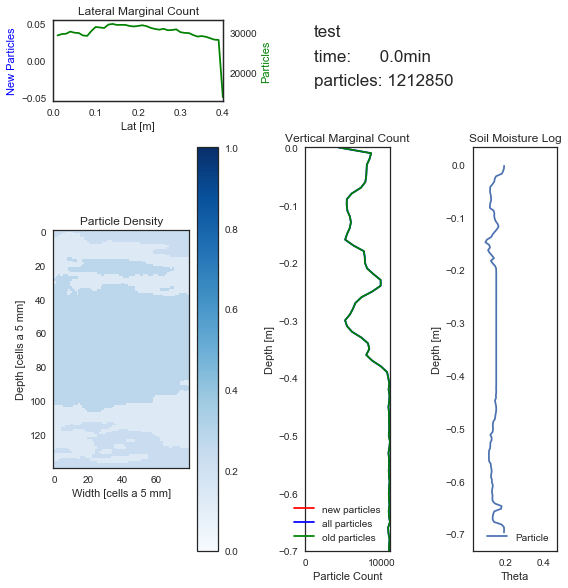

In [28]:
mc.prects=False
#theta=mc.zgrid[:,1]*0.+0.273
#[mc,particles,npart]=rE.particle_setup_obs(theta,mc,vG,dr,pdyn)
[thS,npart]=pdyn.gridupdate_thS(particles.lat,particles.z,mc)
[A,B]=plotparticles_t(particles,thS/100.,mc,vG,store=True)

### Run Model

In [29]:
mc.LTEpercentile=70 #new parameter
particles.LTEbin=np.fmin(particles.LTEbin.values,len(mc.D)-1)

In [30]:
t_end=mc.t_end#6.*3600.
saveDT=True

In [31]:
#1: MDA
#2: MED
#3: rand
infiltmeth='MDA'
#3: RWdiff
#4: Ediss
#exfiltmeth='RWdiff'
exfiltmeth='Ediss'
#5: film_uconst
#6: dynamic u
film=True
#7: maccoat1
#8: maccoat10
#9: maccoat100
macscale=1. #scale the macropore coating 
clogswitch=False
infiltscale=False#0.8


In [32]:
#mc.dt=0.11
#mc.splitfac=5
#pdyn.part_diffusion_binned_pd(particles,npart,thS,mc)

In [33]:
mc.t_out=60

In [34]:
wdir='./'
drained=pd.DataFrame(np.array([]))
leftover=0
output=mc.t_out#10. #mind to set also in TXstore.index definition

dummy=np.floor(mc.t_end/output)
t=0.
ix=0

with h5py.File('./results/S_'+runname+'.h5', 'w') as f:
    dset = f.create_dataset("states", (1,5), dtype='f')
    dset[:] =  [t, len(particles), leftover, len(drained), ix]
    
print('starting new run...')


starting new run...


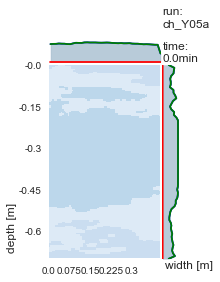

In [35]:
plotparticles_weier(particles,mc,pdyn,vG,runname,t,i,fsize=(2.35, 4),saving=False,relative=False,wdir=wdir)

In [ ]:
#loop through plot cycles
for i in np.arange(dummy.astype(int))[ix:]:
    plotparticles_weier(particles,mc,pdyn,vG,runname,t,i,fsize=(2.35, 4),saving=True,relative=False,wdir=wdir)
    [particles,npart,thS,leftover,drained,t]=rE.CAOSpy_rundx1(i*output,(i+1)*output,mc,pdyn,cinf,precTS,particles,leftover,drained,6.,splitfac=4,prec_2D=False,maccoat=macscale,saveDT=saveDT,clogswitch=clogswitch,infilt_method=infiltmeth,exfilt_method=exfiltmeth,film=film,infiltscale=infiltscale)
    
    print('step '+str(i)+' done.')
    
    with h5py.File(mc.stochsoil, 'r+') as f:
        dset = f["theta"]
        dset[:,:,i]=np.reshape((mc.soilmatrix.loc[mc.soilgrid.ravel()-1,'tr']+(mc.soilmatrix.ts-mc.soilmatrix.tr)[mc.soilgrid.ravel()-1]*thS.ravel()*0.01).values,np.shape(thS))
        
    particles.to_hdf('./results/P_'+runname+'.h5','table')
    with h5py.File('./results/S_'+runname+'.h5', 'r+') as f:
        dset = f["states"]
        dset = [t, len(particles), leftover, len(drained), ix]


'time: 354.0s  |  n_particles: 1212817  |  precip: 0  |  advect: 0  |  exfilt: 0  |  mean v(adv): nannan m/s'

'time: 354.0s  |  n_particles now: 1212816  |  leftover: 0'

step 5 done.


In [37]:
pd.read_hdf('./results/P_' + runname + '.h5', 'table')

,lat,z,conc,temp,age,flag,fastlane,advect,cell,LTEbin,exfilt
1,0.012073,-0.692772,0.0,0.0,0.0,0.0,17,-0.0676,33122,116,0
2,1.195550,-0.684993,0.0,0.0,0.0,0.0,5,-0.0676,32879,155,0
3,1.197194,-0.680904,0.0,0.0,0.0,0.0,9,-0.0676,32879,337,0
4,1.156214,-0.686420,0.0,0.0,0.0,0.0,4,-0.0676,33111,258,0
5,1.184017,-0.691376,0.0,0.0,0.0,0.0,7,-0.0676,33356,309,0
7,1.189548,-0.691876,0.0,0.0,0.0,0.0,19,-0.0676,33357,325,0
8,1.150506,-0.693708,0.0,0.0,0.0,0.0,15,-0.0676,33350,169,0
9,0.046448,-0.691993,0.0,0.0,0.0,0.0,18,-0.0676,33129,461,0
10,0.009578,-0.693552,0.0,0.0,0.0,0.0,0,-0.0676,33121,462,0
11,1.195280,-0.692172,0.0,0.0,0.0,0.0,10,-0.0676,33359,435,0
